This notebook is to use XAI algorithm for deep learning interpretability.

Ref: https://captum.ai/tutorials/TorchVision_Interpret

In [126]:
import os
import sys
import torch
from torchvision import transforms
import wandb
from PIL import Image
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from tqdm.auto import tqdm
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

sys.path.append('..')
from models.baseline import BinaryClassificationDetectionModel
from dataset import transform_default


wandb_api = wandb.Api()

In [151]:
MODEL_ARTIFACT_PATH = 'yuting_fyp/fall_detection/34kgmnwg'
SAMPLE_IMAGES_DIR = 'sample_images/'

sample_images[0].size=(224, 224)


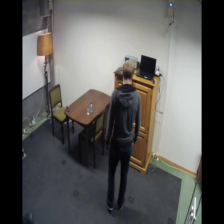

In [122]:
# load sample images
sample_images = [Image.open(os.path.join(SAMPLE_IMAGES_DIR, x)) for x in os.listdir(SAMPLE_IMAGES_DIR)]

# Preprocess the image
input_tensors = [torch.unsqueeze(transform_default(x), 0) for x in sample_images]

print(f'sample_images[0].size={sample_images[0].size}')
sample_images[0]

In [152]:
# download artifacts
run = wandb_api.run(MODEL_ARTIFACT_PATH)
artifacts = run.logged_artifacts()
model = [artifact for artifact in artifacts if artifact.type == 'model'][0]
model_dir = model.download()

wandb: Downloading large artifact model-34kgmnwg:v0, 1583.42MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:5.4


In [153]:
# load the trained model
model = BinaryClassificationDetectionModel.load_from_checkpoint(os.path.join(model_dir, 'model.ckpt'), strict=False)
model.eval()

BinaryClassificationDetectionModel(
  (feature_extractor): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [ ]:
integrated_gradients = IntegratedGradients(model)
dl = DeepLift(model)

probabilities = []
attributions_igs = []
attr_dls = []
labels = []

for input_tensor in tqdm(input_tensors):
    input_tensor = input_tensor[:, :3]
    probability = model.forward(input_tensor).float()
    label = 'Fall' if probability > 0.5 else 'Not Fall'
    attributions_ig = integrated_gradients.attribute(input_tensor, n_steps=200)
    attr_dl = dl.attribute(input_tensor, baselines=input_tensor * 0)
    
    probabilities.append(probability)
    attributions_igs.append(attributions_ig)
    attr_dls.append(attr_dl)
    labels.append(label)

# Visualize the result

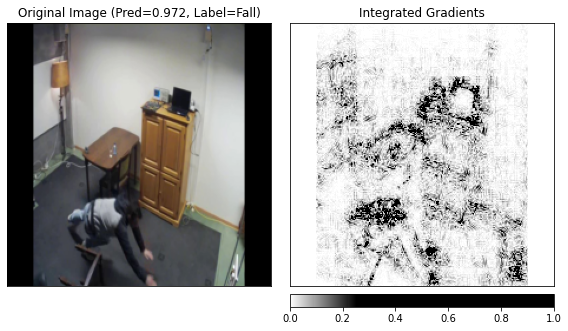

In [150]:
IMAGE_ID = 3

_ = viz.visualize_image_attr_multiple(np.transpose(attributions_igs[IMAGE_ID].squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(np.array(sample_images[IMAGE_ID]), (0, 1, 2)),
                                      ["original_image", "heat_map"],
                                      ["all", "absolute_value"],
                                      cmap=default_cmap,
                                      show_colorbar=True,
                                      titles=[f'Original Image (Pred={round(probabilities[IMAGE_ID].item(), 3)}, Label={labels[IMAGE_ID]})', 'Integrated Gradients'])